## Setup

In [1]:
import pandas as pd
import numpy as np
import requests
import json

import matplotlib.pyplot as plt
from scipy.stats import linregress

from pathlib import Path
from census import Census
from my_api_keys import census_key

## Datasets

In [2]:
CA_cases_per_100_path = Path("Datasets/CA_adults_with_diabetes_per_100.csv")
CA_cases_per_100_data = pd.read_csv(CA_cases_per_100_path)

In [3]:
CA_cases_per_100_data.head()

,Geography,Year,Strata,Strata Name,Percent,Lower 95% CL,Upper 95% CL,Standard Error
0,California,2018,Total population,Total population,10.4,8.9,11.9,0.8
1,California,2018,Race-Ethnicity,White,8.4,6.9,9.9,0.8
2,California,2018,Race-Ethnicity,African-American,12.3,6.0,18.6,3.2
3,California,2018,Race-Ethnicity,Asian,8.5,3.2,13.9,2.7
4,California,2018,Race-Ethnicity,Hispanic,12.1,9.0,15.1,1.6


In [4]:
weekly_deaths_countries_path = Path("Datasets/Weekly_Counts_of_Death_by_Diabetes.csv")
weekly_deaths_countries_data = pd.read_csv(weekly_deaths_countries_path)

In [5]:
weekly_deaths_countries_data.head()

,Jurisdiction,Week Ending Date,State Abbreviation,Year,Week,Cause Group,Number of Deaths,Cause Subgroup,Time Period,Suppress,Note,Average Number of Deaths in Time Period,Difference from 2015-2019 to 2020,Percent Difference from 2015-2019 to 2020,Type
0,Alabama,01/10/2015,AL,2015,1,Alzheimer disease and dementia,120,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
1,Alabama,01/10/2015,AL,2015,1,Alzheimer disease and dementia,120,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Unweighted
2,Alabama,01/09/2016,AL,2016,1,Alzheimer disease and dementia,76,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
3,Alabama,01/09/2016,AL,2016,1,Alzheimer disease and dementia,76,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Unweighted
4,Alabama,01/07/2017,AL,2017,1,Alzheimer disease and dementia,96,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)


In [6]:
population_variable = "B01003_001E"
income_variable = "B19013_001E"
employment_employed_variable = "B23025_004E"
poverty_variable = "B17001_002E"

In [7]:
url = f"https://api.census.gov/data/2019/acs/acs5?get=NAME,{population_variable},{income_variable},{employment_employed_variable},{poverty_variable}&for=state:*&key={census_key}"

census_data = requests.get(url).json()

## Prep Census and Merge with Diabetes Death Info

In [8]:
weekly_deaths_countries_data.head()

,Jurisdiction,Week Ending Date,State Abbreviation,Year,Week,Cause Group,Number of Deaths,Cause Subgroup,Time Period,Suppress,Note,Average Number of Deaths in Time Period,Difference from 2015-2019 to 2020,Percent Difference from 2015-2019 to 2020,Type
0,Alabama,01/10/2015,AL,2015,1,Alzheimer disease and dementia,120,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
1,Alabama,01/10/2015,AL,2015,1,Alzheimer disease and dementia,120,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Unweighted
2,Alabama,01/09/2016,AL,2016,1,Alzheimer disease and dementia,76,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)
3,Alabama,01/09/2016,AL,2016,1,Alzheimer disease and dementia,76,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Unweighted
4,Alabama,01/07/2017,AL,2017,1,Alzheimer disease and dementia,96,Alzheimer disease and dementia,2015-2019,NaN,NaN,103,NaN,NaN,Predicted (weighted)


In [9]:
#extract data where "Cause Subgroup" is "Diabetes" and "Type" is "Unweighted"
#if we don't specify "Type" there will be duplicates
weekly_diabetes_deaths = weekly_deaths_countries_data.loc[(weekly_deaths_countries_data["Cause Subgroup"] == "Diabetes") & (weekly_deaths_countries_data["Type"] == "Unweighted")]

#extract only the relevant columns
weekly_diabetes_deaths = weekly_diabetes_deaths[["Jurisdiction", "Week Ending Date", "Number of Deaths", "Cause Subgroup"]]

weekly_diabetes_deaths.head()

,Jurisdiction,Week Ending Date,Number of Deaths,Cause Subgroup
285699,Alabama,01/10/2015,36,Diabetes
285701,Alabama,01/09/2016,32,Diabetes
285703,Alabama,01/07/2017,25,Diabetes
285705,Alabama,01/06/2018,34,Diabetes
285707,Alabama,01/05/2019,22,Diabetes


In [10]:
#convert "Week Ending Date" into datetime
#make new columns of month and year
weekly_diabetes_deaths["Month"] = pd.to_datetime(weekly_diabetes_deaths["Week Ending Date"]).dt.month
weekly_diabetes_deaths["Year"] = pd.to_datetime(weekly_diabetes_deaths["Week Ending Date"]).dt.year

#remove data from after 2020 (the census data ends in 2020)
weekly_diabetes_deaths = weekly_diabetes_deaths.loc[weekly_diabetes_deaths["Year"] <= 2020]

In [11]:
#sum deaths by state and year
weekly_diabetes_deaths = pd.DataFrame({
    "Number of Diabetes Deaths":weekly_diabetes_deaths.groupby(["Jurisdiction", "Year"])["Number of Deaths"].sum()
})

weekly_diabetes_deaths = weekly_diabetes_deaths.reset_index()

weekly_diabetes_deaths

,Jurisdiction,Year,Number of Diabetes Deaths
0,Alabama,2015,1139
1,Alabama,2016,1161
2,Alabama,2017,1133
3,Alabama,2018,1133
4,Alabama,2019,1196
...,...,...,...
280,Wisconsin,2016,1446
281,Wisconsin,2017,1420
282,Wisconsin,2018,1518
283,Wisconsin,2019,1537


In [12]:
census_column_names = ["State", "Year", "Population", "Median Household Income", "Number of People Employed", "Number of People in Poverty"]
census_df = pd.DataFrame(columns = census_column_names)

census_df

,State,Year,Population,Median Household Income,Number of People Employed,Number of People in Poverty


In [13]:
#extract years in the weekly deaths data
#will be used to extract census data by year
years_list = weekly_diabetes_deaths["Year"].unique()
years_list = list(years_list)

years_list

[2015, 2016, 2017, 2018, 2019, 2020]

In [14]:
#list will become column in census_df
name_values = []
population_values = []
income_values = []
employment_values = []
poverty_values = []
year_values = []

#loop through the years we have of weekly deaths data
#for each year fetch the census data
for year in years_list:
    
    url = f"https://api.census.gov/data/{year}/acs/acs5?get=NAME,{population_variable},{income_variable},{employment_employed_variable},{poverty_variable}&for=state:*&key={census_key}"
    census_data_by_year = requests.get(url).json()
    
    #loop through each state
    #add state data to lists
    for i in range(0, 51):
        state_name = census_data_by_year[i][0]
        name_values.append(state_name)
    
        state_population = census_data_by_year[i][1]
        population_values.append(state_population)
    
        state_income = census_data_by_year[i][2]
        income_values.append(state_income)
    
        state_employment = census_data_by_year[i][3]
        employment_values.append(state_employment)
    
        state_poverty = census_data_by_year[i][4]
        poverty_values.append(state_poverty)
        
        year_values.append(year)
    
    print(f"{year} data complete")

#put the list into relevant column
census_df["State"] = name_values
census_df["Year"] = year_values
census_df["Population"] = population_values
census_df["Median Household Income"] = income_values
census_df["Number of People Employed"] = employment_values
census_df["Number of People in Poverty"] = poverty_values

2015 data complete
2016 data complete
2017 data complete
2018 data complete
2019 data complete
2020 data complete


In [15]:
census_df.head()

,State,Year,Population,Median Household Income,Number of People Employed,Number of People in Poverty
0,NAME,2015,B01003_001E,B19013_001E,B23025_004E,B17001_002E
1,Mississippi,2015,2988081,39665,1203914,651545
2,Missouri,2015,6045448,48173,2807996,915972
3,Montana,2015,1014699,47169,485446,150586
4,Nebraska,2015,1869365,52997,968134,231115


In [16]:
#remove Wyoming data since it's not in the weekly deaths data

census_df = census_df.loc[(census_df["State"] != "NAME") & (census_df["State"] != "Wyoming")]
census_df.head()

,State,Year,Population,Median Household Income,Number of People Employed,Number of People in Poverty
1,Mississippi,2015,2988081,39665,1203914,651545
2,Missouri,2015,6045448,48173,2807996,915972
3,Montana,2015,1014699,47169,485446,150586
4,Nebraska,2015,1869365,52997,968134,231115
5,Nevada,2015,2798636,51847,1267312,426337


In [17]:
#change "Jurisdiction" column to be named "State"
weekly_diabetes_deaths = weekly_diabetes_deaths.rename(columns = {"Jurisdiction":"State"})
weekly_diabetes_deaths.head()

,State,Year,Number of Diabetes Deaths
0,Alabama,2015,1139
1,Alabama,2016,1161
2,Alabama,2017,1133
3,Alabama,2018,1133
4,Alabama,2019,1196


In [18]:
#merge weekly deaths data and census data by "State" and "Year"
weekly_deaths_and_census = pd.merge(weekly_diabetes_deaths, census_df, how = 'inner', left_on = ['State', 'Year'], right_on = ['State', 'Year'])
weekly_deaths_and_census

,State,Year,Number of Diabetes Deaths,Population,Median Household Income,Number of People Employed,Number of People in Poverty
0,Alabama,2015,1139,4830620,43623,2022325,887260
1,Alabama,2016,1161,4841164,44758,2042025,868666
2,Alabama,2017,1133,4850771,46472,2055509,849699
3,Alabama,2018,1133,4864680,48486,2076708,829400
4,Alabama,2019,1196,4876250,50536,2097384,795989
...,...,...,...,...,...,...,...
257,Wisconsin,2016,1446,5754798,54610,2910339,713472
258,Wisconsin,2017,1420,5763217,56759,2939880,692719
259,Wisconsin,2018,1518,5778394,59209,2964540,668220
260,Wisconsin,2019,1537,5790716,61747,2982359,639160


In [19]:
#change to numeric instead of string so we can perform operations
weekly_deaths_and_census[["Number of Diabetes Deaths", "Median Household Income", "Number of People Employed", "Number of People in Poverty"]] = weekly_deaths_and_census[["Number of Diabetes Deaths", "Median Household Income", "Number of People Employed", "Number of People in Poverty"]].astype(float)
weekly_deaths_and_census[["Year", "Population"]] = weekly_deaths_and_census[["Year", "Population"]].astype(int)

In [20]:
weekly_deaths_and_census["Number of People Employed"] = (weekly_deaths_and_census["Number of People Employed"] / weekly_deaths_and_census["Population"]) * 100
weekly_deaths_and_census["Number of People in Poverty"] = (weekly_deaths_and_census["Number of People in Poverty"] / weekly_deaths_and_census["Population"]) * 100
weekly_deaths_and_census["Number of Diabetes Deaths"] = (weekly_deaths_and_census["Number of Diabetes Deaths"] / weekly_deaths_and_census["Population"]) * 100

In [21]:
weekly_deaths_and_census = weekly_deaths_and_census.rename(columns = {"Number of Diabetes Deaths":"Population Dead by Diabetes (%)", "Number of People Employed": "Population Employed (%)", "Number of People in Poverty":"Population in Poverty (%)"})
weekly_deaths_and_census

,State,Year,Population Dead by Diabetes (%),Population,Median Household Income,Population Employed (%),Population in Poverty (%)
0,Alabama,2015,0.023579,4830620,43623.0,41.864709,18.367415
1,Alabama,2016,0.023982,4841164,44758.0,42.180455,17.943329
2,Alabama,2017,0.023357,4850771,46472.0,42.374893,17.516782
3,Alabama,2018,0.023290,4864680,48486.0,42.689509,17.049426
4,Alabama,2019,0.024527,4876250,50536.0,43.012233,16.323794
...,...,...,...,...,...,...,...
257,Wisconsin,2016,0.025127,5754798,54610.0,50.572392,12.397863
258,Wisconsin,2017,0.024639,5763217,56759.0,51.011093,12.019658
259,Wisconsin,2018,0.026270,5778394,59209.0,51.303874,11.564113
260,Wisconsin,2019,0.026542,5790716,61747.0,51.502422,11.037668


In [22]:
CA_cases_per_100_total_pop_data = CA_cases_per_100_data.loc[CA_cases_per_100_data["Strata"] == "Total population"]
CA_cases_per_100_total_pop_data = CA_cases_per_100_total_pop_data[["Geography", "Year", "Percent"]]
CA_cases_per_100_total_pop_data = CA_cases_per_100_total_pop_data.rename(columns = {"Geography":"State", "Percent":"(Estimated) Population with Diabetes (%)"})

CA_cases_per_100_total_pop_data

,State,Year,(Estimated) Population with Diabetes (%)
0,California,2018,10.4
21,California,2017,8.2
42,California,2016,10.2
63,California,2015,9.0
84,California,2014,9.4
105,California,2013,9.5
126,California,2012,9.2


In [23]:
CA_census_and_deaths_data = weekly_deaths_and_census.loc[weekly_deaths_and_census["State"] == "California"]

CA_census_and_deaths_data

,State,Year,Population Dead by Diabetes (%),Population,Median Household Income,Population Employed (%),Population in Poverty (%)
18,California,2015,0.022472,38421464,61818.0,44.887306,15.968007
19,California,2016,0.023915,38654206,63783.0,45.472780,15.533257
20,California,2017,0.024560,38982847,67169.0,46.158545,14.810124
21,California,2018,0.024325,39148760,71228.0,46.767795,14.016130
22,California,2019,0.025016,39283497,75235.0,47.325830,13.109174
23,California,2020,0.029213,39346023,78672.0,47.392068,12.335259


In [24]:
CA_census_and_deaths_perc_data = pd.merge(CA_census_and_deaths_data, CA_cases_per_100_total_pop_data, how = 'inner', left_on = ['State', 'Year'], right_on = ['State', 'Year'])
CA_census_and_deaths_perc_data

,State,Year,Population Dead by Diabetes (%),Population,Median Household Income,Population Employed (%),Population in Poverty (%),(Estimated) Population with Diabetes (%)
0,California,2015,0.022472,38421464,61818.0,44.887306,15.968007,9.0
1,California,2016,0.023915,38654206,63783.0,45.472780,15.533257,10.2
2,California,2017,0.024560,38982847,67169.0,46.158545,14.810124,8.2
3,California,2018,0.024325,39148760,71228.0,46.767795,14.016130,10.4


In [25]:
average_deaths = list(weekly_deaths_and_census.groupby("Year")["Population Dead by Diabetes (%)"].mean())
average_population = list(weekly_deaths_and_census.groupby("Year")["Population"].mean())
average_income = list(weekly_deaths_and_census.groupby("Year")["Median Household Income"].mean())
average_employed = list(weekly_deaths_and_census.groupby("Year")["Population Employed (%)"].mean())
average_poverty = list(weekly_deaths_and_census.groupby("Year")["Population in Poverty (%)"].mean())

In [26]:
USA_averages_data = pd.DataFrame({
    "Year": [2015, 2016, 2017, 2018, 2019, 2020],
    "Average Population Dead by Diabetes (%)":average_deaths,
    "Average Population":average_population, 
    "Average Median Household Income":average_income, 
    "Average Population Employed (%)":average_employed, 
    "Average Population in Poverty (%)":average_poverty
})

USA_averages_data

,Year,Average Population Dead by Diabetes (%),Average Population,Average Median Household Income,Average Population Employed (%),Average Population in Poverty (%)
0,2015,0.023243,7.097218e+06,52221.119048,45.889859,15.654588
1,2016,0.024146,7.013954e+06,54147.325581,46.214550,15.209208
2,2017,0.025103,7.158523e+06,55509.883721,46.575400,14.906538
3,2018,0.024875,6.941314e+06,59079.545455,47.080720,14.349018
4,2019,0.024617,7.251913e+06,62443.113636,47.808913,12.883947
5,2020,0.028841,6.946276e+06,63613.478261,47.593793,12.952921


In [27]:
CA_census_and_deaths_data

,State,Year,Population Dead by Diabetes (%),Population,Median Household Income,Population Employed (%),Population in Poverty (%)
18,California,2015,0.022472,38421464,61818.0,44.887306,15.968007
19,California,2016,0.023915,38654206,63783.0,45.472780,15.533257
20,California,2017,0.024560,38982847,67169.0,46.158545,14.810124
21,California,2018,0.024325,39148760,71228.0,46.767795,14.016130
22,California,2019,0.025016,39283497,75235.0,47.325830,13.109174
23,California,2020,0.029213,39346023,78672.0,47.392068,12.335259


## Is California an outlier?

NOTE: some states are missing (ex: Alaska) bc they don't have weekly diabetes deaths data

In [28]:
# Define a function to create Linear Regression plots
def linear_regression(df, x_values, y_values):
    
    plt.scatter(df[x_values], df[y_values])
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(df[x_values], df[y_values])
    regress_values = (df[x_values] * slope) + intercept
    
    line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
    plt.plot(df[x_values], regress_values, "r-")
    
    plt.xlabel(x_values)
    plt.ylabel(y_values)
    
    print(f"The r-value is: {rvalue}")

Text(0.5, 1.0, 'Year vs Population Dead by Diabetes (%)')

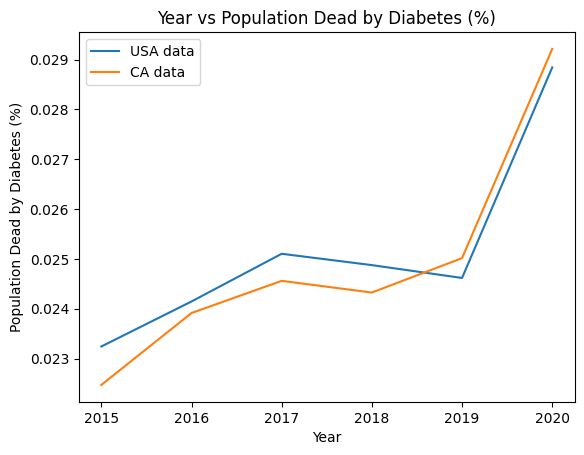

In [29]:
plt.plot(USA_averages_data["Year"], USA_averages_data["Average Population Dead by Diabetes (%)"], label = "USA data")
plt.plot(CA_census_and_deaths_data["Year"], CA_census_and_deaths_data["Population Dead by Diabetes (%)"], label = "CA data")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Population Dead by Diabetes (%)")
plt.title("Year vs Population Dead by Diabetes (%)")

(2500000.0, 42500000.0)

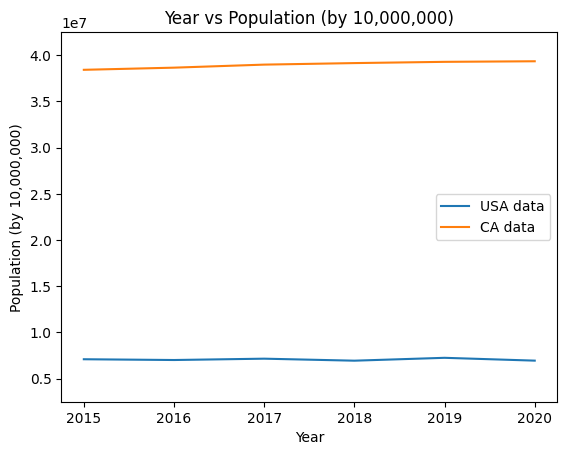

In [30]:
plt.plot(USA_averages_data["Year"], USA_averages_data["Average Population"], label = "USA data")
plt.plot(CA_census_and_deaths_data["Year"], CA_census_and_deaths_data["Population"], label = "CA data")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Population (by 10,000,000)")
plt.title("Year vs Population (by 10,000,000)")
plt.ylim(2500000, 42500000)

Text(0.5, 1.0, 'Year vs Median Household Income')

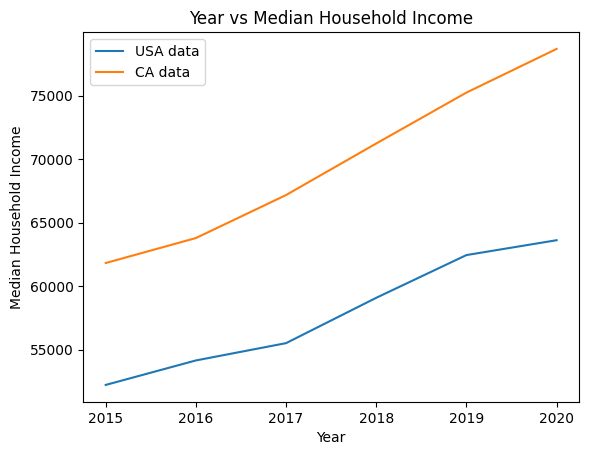

In [31]:
plt.plot(USA_averages_data["Year"], USA_averages_data["Average Median Household Income"], label = "USA data")
plt.plot(CA_census_and_deaths_data["Year"], CA_census_and_deaths_data["Median Household Income"], label = "CA data")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Median Household Income")
plt.title("Year vs Median Household Income")

Text(0.5, 1.0, 'Year vs Population Employed (%)')

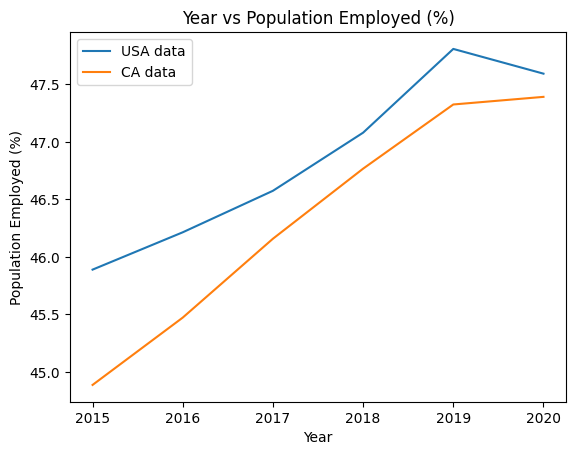

In [32]:
plt.plot(USA_averages_data["Year"], USA_averages_data["Average Population Employed (%)"], label = "USA data")
plt.plot(CA_census_and_deaths_data["Year"], CA_census_and_deaths_data["Population Employed (%)"], label = "CA data")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Population Employed (%)")
plt.title("Year vs Population Employed (%)")

Text(0.5, 1.0, 'Year vs Population in Poverty (%)')

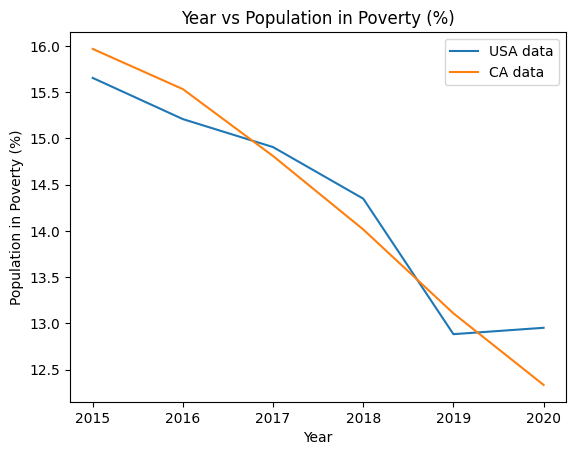

In [33]:
plt.plot(USA_averages_data["Year"], USA_averages_data["Average Population in Poverty (%)"], label = "USA data")
plt.plot(CA_census_and_deaths_data["Year"], CA_census_and_deaths_data["Population in Poverty (%)"], label = "CA data")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Population in Poverty (%)")
plt.title("Year vs Population in Poverty (%)")

## (Summary) Is California an outlier?

From 2015-2020, CA was similar to the rest of the USA in terms of the percentage of population dead by diabetes and the percentage of population in poverty.

CA has a much higher population and median household income then the average of the USA. Interestingly, the percentage of population employed in CA is lower than the average of the USA.

In [34]:
CA_census_and_deaths_data

,State,Year,Population Dead by Diabetes (%),Population,Median Household Income,Population Employed (%),Population in Poverty (%)
18,California,2015,0.022472,38421464,61818.0,44.887306,15.968007
19,California,2016,0.023915,38654206,63783.0,45.472780,15.533257
20,California,2017,0.024560,38982847,67169.0,46.158545,14.810124
21,California,2018,0.024325,39148760,71228.0,46.767795,14.016130
22,California,2019,0.025016,39283497,75235.0,47.325830,13.109174
23,California,2020,0.029213,39346023,78672.0,47.392068,12.335259


The r-value is: 0.7649425658959949


Text(0.5, 1.0, '(CA) Population vs Population Dead by Diabetes (%)')

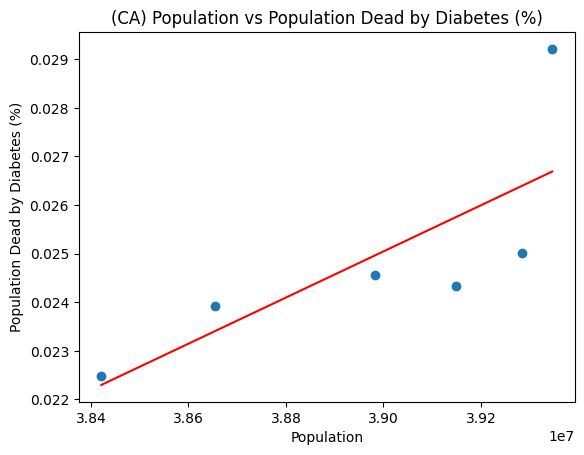

In [35]:
linear_regression(CA_census_and_deaths_data, "Population", "Population Dead by Diabetes (%)")
plt.title("(CA) Population vs Population Dead by Diabetes (%)")

The r-value is: 0.8571779179980145


Text(0.5, 1.0, '(CA) Median Household Income vs Population Dead by Diabetes (%)')

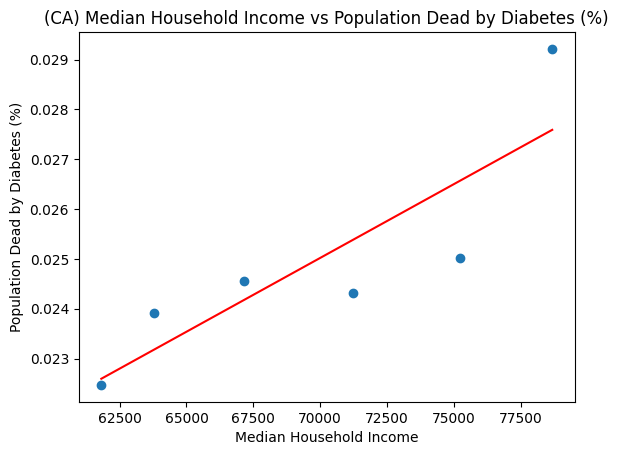

In [36]:
linear_regression(CA_census_and_deaths_data, "Median Household Income", "Population Dead by Diabetes (%)")
plt.title("(CA) Median Household Income vs Population Dead by Diabetes (%)")

The r-value is: 0.7653861414625703


Text(0.5, 1.0, '(CA) Population Employed (%) vs Population Dead by Diabetes (%)')

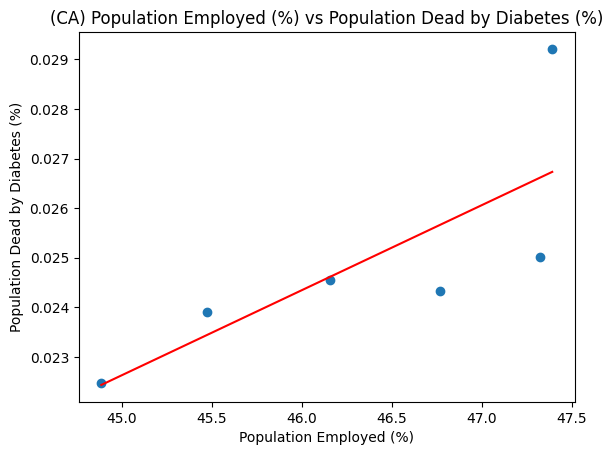

In [37]:
linear_regression(CA_census_and_deaths_data, "Population Employed (%)", "Population Dead by Diabetes (%)")
plt.title("(CA) Population Employed (%) vs Population Dead by Diabetes (%)")

The r-value is: -0.8658371876224651


Text(0.5, 1.0, '(CA) Population in Poverty (%) vs Population Dead by Diabetes (%)')

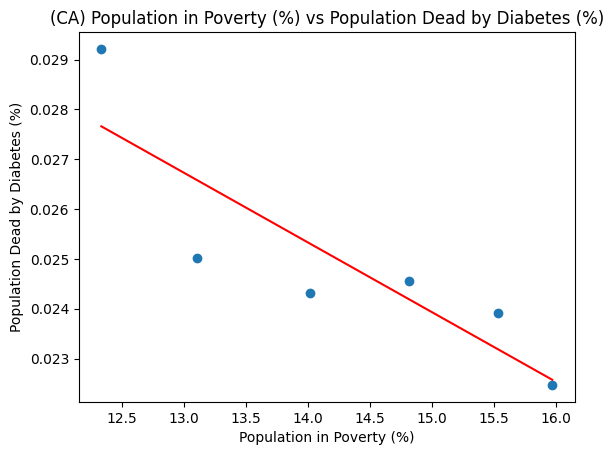

In [38]:
linear_regression(CA_census_and_deaths_data, "Population in Poverty (%)", "Population Dead by Diabetes (%)")
plt.title("(CA) Population in Poverty (%) vs Population Dead by Diabetes (%)")

## (Summary) Is California an outlier?

According to the data from 2015-2020, population dead by diabetes has a strong linear correlation with population, median household income, population employed, and population in poverty.

Population in poverty and population dead by diabetes have a negative correlation, while the other variables have a positive correlation with population dead by diabetes. 

One may not expect that median household income and population dead by diabetes would have a positive correlation. However, this may be due to the fact that median household income is increasing in CA (see graph of Year vs Median Household Income). Similarly, one may not expect for population employed to be positively correlate as well. Though this may be caused by the fact that the population employed is increasing (see graph of Year vs Population Employed (%)).

## Does diabetes death correlate with poverty/GDP/population, employment?

NOTE: some states are missing (ex: Alaska) bc they don't have weekly diabetes deaths data

### USA Averages

In [39]:
USA_averages_data

,Year,Average Population Dead by Diabetes (%),Average Population,Average Median Household Income,Average Population Employed (%),Average Population in Poverty (%)
0,2015,0.023243,7.097218e+06,52221.119048,45.889859,15.654588
1,2016,0.024146,7.013954e+06,54147.325581,46.214550,15.209208
2,2017,0.025103,7.158523e+06,55509.883721,46.575400,14.906538
3,2018,0.024875,6.941314e+06,59079.545455,47.080720,14.349018
4,2019,0.024617,7.251913e+06,62443.113636,47.808913,12.883947
5,2020,0.028841,6.946276e+06,63613.478261,47.593793,12.952921


The r-value is: -0.43359811614583005


Text(0.5, 1.0, '(USA) Average Population vs Average Population Dead by Diabetes (%)')

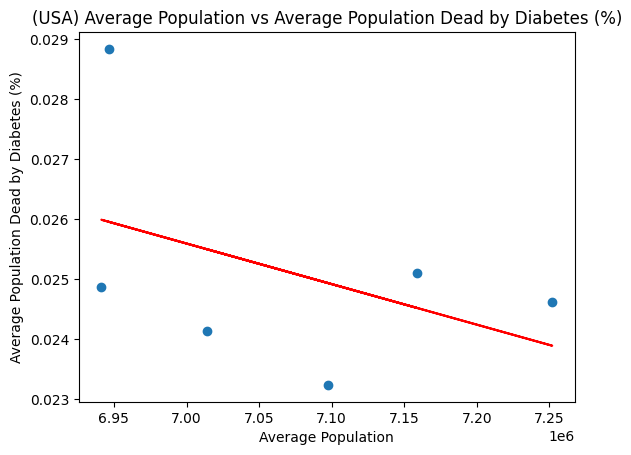

In [40]:
linear_regression(USA_averages_data, "Average Population", "Average Population Dead by Diabetes (%)")
plt.title("(USA) Average Population vs Average Population Dead by Diabetes (%)")

The r-value is: 0.7413672671221603


Text(0.5, 1.0, '(USA) Average Median Household Income vs Average Population Dead by Diabetes (%)')

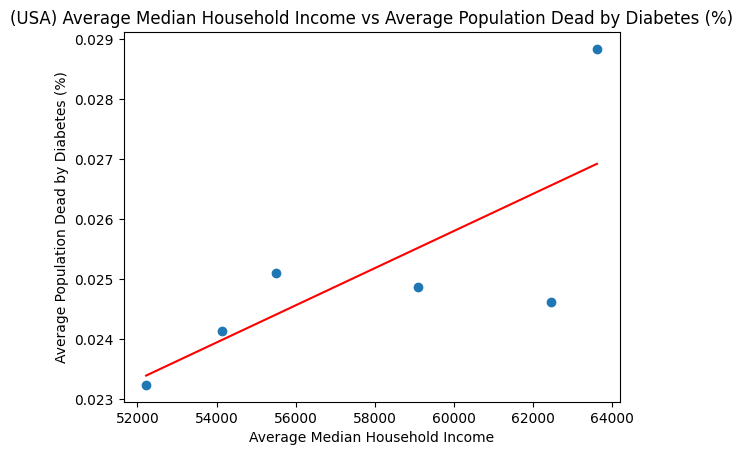

In [41]:
linear_regression(USA_averages_data, "Average Median Household Income", "Average Population Dead by Diabetes (%)")
plt.title("(USA) Average Median Household Income vs Average Population Dead by Diabetes (%)")

The r-value is: 0.6303763393098294


Text(0.5, 1.0, '(USA) Average Population Employed (%) vs Average Population Dead by Diabetes (%)')

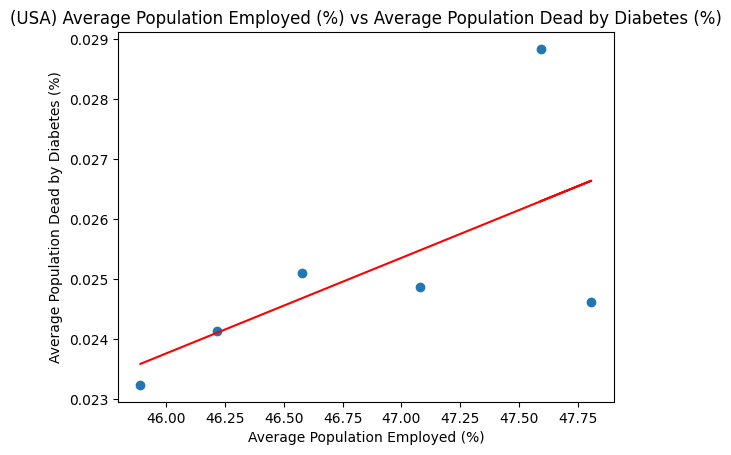

In [42]:
linear_regression(USA_averages_data, "Average Population Employed (%)", "Average Population Dead by Diabetes (%)")
plt.title("(USA) Average Population Employed (%) vs Average Population Dead by Diabetes (%)")

The r-value is: -0.686583048087591


Text(0.5, 1.0, '(USA) Average Population in Poverty (%) vs Average Population Dead by Diabetes (%)')

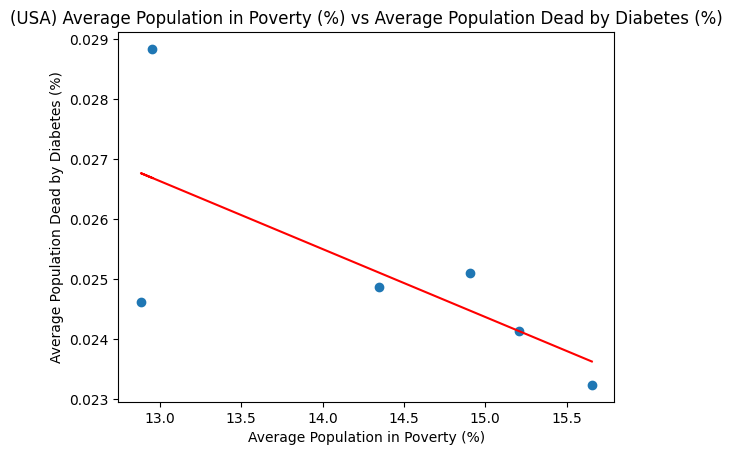

In [43]:
linear_regression(USA_averages_data, "Average Population in Poverty (%)", "Average Population Dead by Diabetes (%)")
plt.title("(USA) Average Population in Poverty (%) vs Average Population Dead by Diabetes (%)")

## (Summary) Does diabetes death correlate with poverty/GDP/population, employment?

We see a similar situation as in CA, except this time average population and average population dead by diabetes are negatively correlated. The linear correlation are also less strong than in CA.

In an effort to understand why the data isn't showing what we expect, we will use the entirety of the data instead of averaging it. 

### USA All Data

Text(0.5, 1.0, '(USA) Population (by 10,000,000) vs Population Dead by Diabetes (%)')

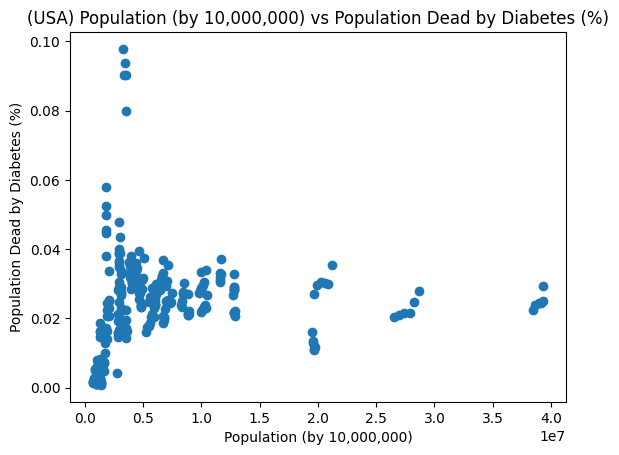

In [44]:
plt.scatter(weekly_deaths_and_census["Population"], weekly_deaths_and_census["Population Dead by Diabetes (%)"])
plt.xlabel("Population (by 10,000,000)")
plt.ylabel("Population Dead by Diabetes (%)")
plt.title("(USA) Population (by 10,000,000) vs Population Dead by Diabetes (%)")

Text(0.5, 1.0, '(USA) Median Household Income vs Population Dead by Diabetes (%)')

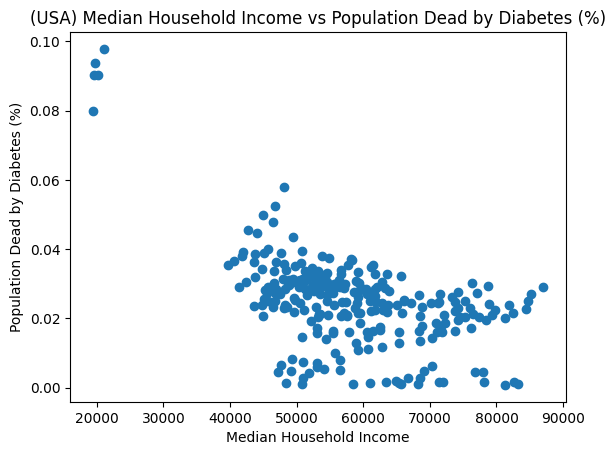

In [45]:
plt.scatter(weekly_deaths_and_census["Median Household Income"], weekly_deaths_and_census["Population Dead by Diabetes (%)"])
plt.xlabel("Median Household Income")
plt.ylabel("Population Dead by Diabetes (%)")
plt.title("(USA) Median Household Income vs Population Dead by Diabetes (%)")

In [46]:
weekly_deaths_and_census.loc[weekly_deaths_and_census["Median Household Income"] < 30000]

,State,Year,Population Dead by Diabetes (%),Population,Median Household Income,Population Employed (%),Population in Poverty (%)
204,Puerto Rico,2015,0.079931,3583073,19350.0,29.677040,45.104216
205,Puerto Rico,2016,0.090214,3529385,19606.0,29.894897,44.684131
206,Puerto Rico,2017,0.093630,3468963,19775.0,29.984062,44.486494
207,Puerto Rico,2018,0.090347,3386941,20166.0,30.366635,44.144849
208,Puerto Rico,2020,0.097799,3255642,21058.0,31.526194,43.031697


Text(0.5, 1.0, '(USA) Population Employed (%) vs Population Dead by Diabetes (%)')

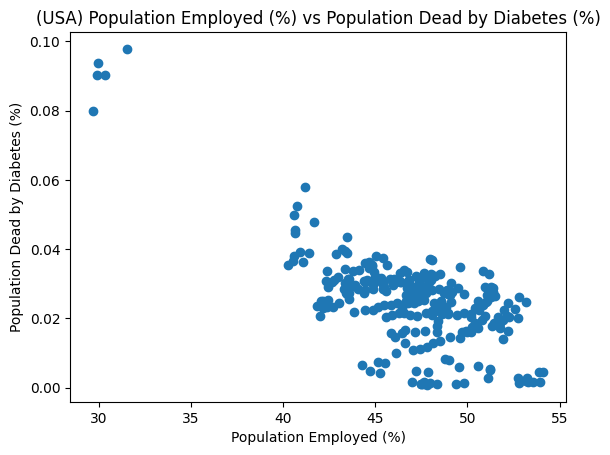

In [47]:
plt.scatter(weekly_deaths_and_census["Population Employed (%)"], weekly_deaths_and_census["Population Dead by Diabetes (%)"])
plt.xlabel("Population Employed (%)")
plt.ylabel("Population Dead by Diabetes (%)")
plt.title("(USA) Population Employed (%) vs Population Dead by Diabetes (%)")

In [48]:
weekly_deaths_and_census.loc[weekly_deaths_and_census["Population Employed (%)"] < 35]

,State,Year,Population Dead by Diabetes (%),Population,Median Household Income,Population Employed (%),Population in Poverty (%)
204,Puerto Rico,2015,0.079931,3583073,19350.0,29.677040,45.104216
205,Puerto Rico,2016,0.090214,3529385,19606.0,29.894897,44.684131
206,Puerto Rico,2017,0.093630,3468963,19775.0,29.984062,44.486494
207,Puerto Rico,2018,0.090347,3386941,20166.0,30.366635,44.144849
208,Puerto Rico,2020,0.097799,3255642,21058.0,31.526194,43.031697


Text(0.5, 1.0, '(USA) Population in Poverty (%) vs Population Dead by Diabetes (%)')

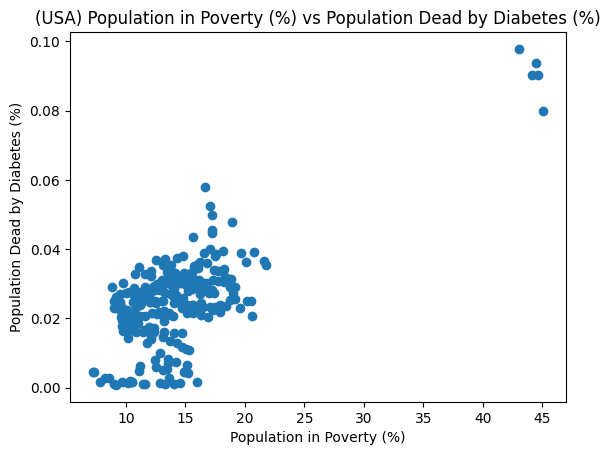

In [49]:
plt.scatter(weekly_deaths_and_census["Population in Poverty (%)"], weekly_deaths_and_census["Population Dead by Diabetes (%)"])
plt.xlabel("Population in Poverty (%)")
plt.ylabel("Population Dead by Diabetes (%)")
plt.title("(USA) Population in Poverty (%) vs Population Dead by Diabetes (%)")

In [50]:
weekly_deaths_and_census.loc[weekly_deaths_and_census["Population in Poverty (%)"] > 25]

,State,Year,Population Dead by Diabetes (%),Population,Median Household Income,Population Employed (%),Population in Poverty (%)
204,Puerto Rico,2015,0.079931,3583073,19350.0,29.677040,45.104216
205,Puerto Rico,2016,0.090214,3529385,19606.0,29.894897,44.684131
206,Puerto Rico,2017,0.093630,3468963,19775.0,29.984062,44.486494
207,Puerto Rico,2018,0.090347,3386941,20166.0,30.366635,44.144849
208,Puerto Rico,2020,0.097799,3255642,21058.0,31.526194,43.031697


## (Summary) Does diabetes death correlate with poverty/GDP/population, employment?

In all of these graphs there is a collection of points that are far away from the rest. In each case these points represent Puerto Rico. We will remove these points, and just look at the mainland USA.

### USA w/o Puerto Rico Data

In [51]:
weekly_deaths_and_census_states = weekly_deaths_and_census.loc[weekly_deaths_and_census["State"] != "Puerto Rico"]

The r-value is: 0.13085606834349797


Text(0.5, 1.0, '(USA) Population (by 10,000,000) vs Population Dead by Diabetes (%)')

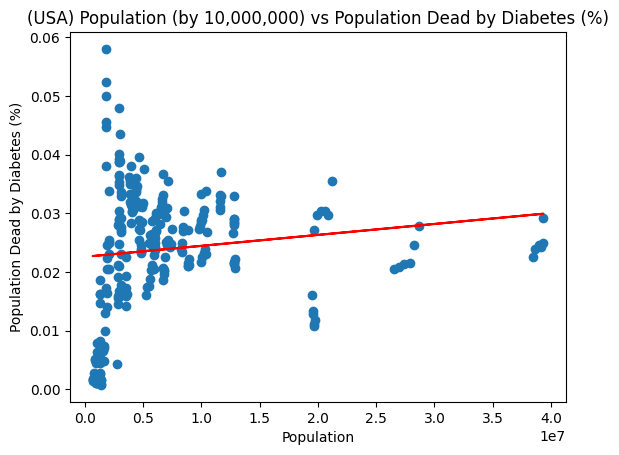

In [52]:
linear_regression(weekly_deaths_and_census_states, "Population", "Population Dead by Diabetes (%)")
plt.title("(USA) Population (by 10,000,000) vs Population Dead by Diabetes (%)")

The r-value is: -0.39988022220688524


Text(0.5, 1.0, '(USA) Median Household Income vs Population Dead by Diabetes (%)')

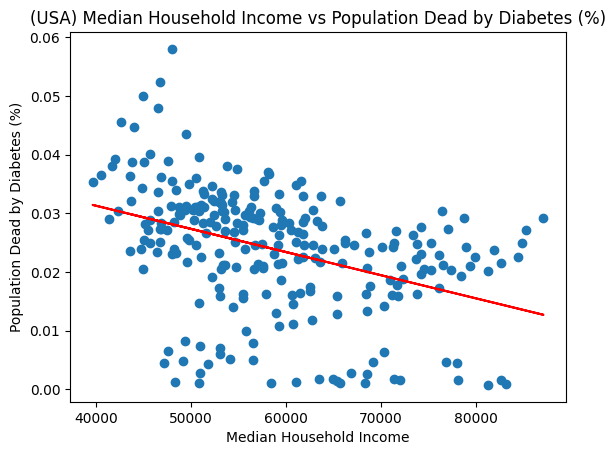

In [53]:
linear_regression(weekly_deaths_and_census_states, "Median Household Income", "Population Dead by Diabetes (%)")
plt.title("(USA) Median Household Income vs Population Dead by Diabetes (%)")

The r-value is: -0.5310362238632678


Text(0.5, 1.0, '(USA) Population Employed (%) vs Population Dead by Diabetes (%)')

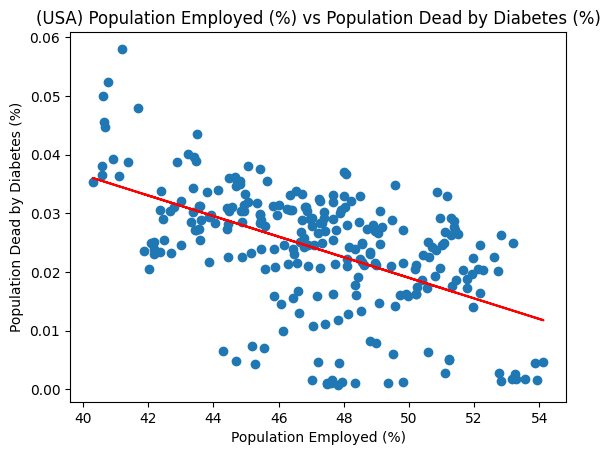

In [54]:
linear_regression(weekly_deaths_and_census_states, "Population Employed (%)", "Population Dead by Diabetes (%)")
plt.title("(USA) Population Employed (%) vs Population Dead by Diabetes (%)")

The r-value is: 0.4564577374233568


Text(0.5, 1.0, '(USA) Population in Poverty (%) vs Population Dead by Diabetes (%)')

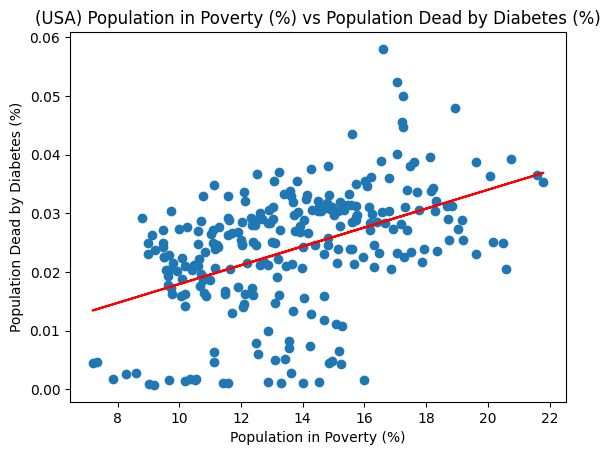

In [55]:
linear_regression(weekly_deaths_and_census_states, "Population in Poverty (%)", "Population Dead by Diabetes (%)")
plt.title("(USA) Population in Poverty (%) vs Population Dead by Diabetes (%)")

## (Summary) Does diabetes death correlate with poverty/GDP/population, employment?

 When looking at the entirety of the data the results are different. Not only are the correlations less strong, but population dead by diabetes is now negatively correlated with median household income and population employed.